In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

In [11]:
batch_size = 40
img_height = 200
img_width = 200

Keras dataset preprocessing utilities, located at tf.keras.preprocessing, help you go from raw data on disk to a tf.data.Dataset object that can be used to train a model.

See https://keras.io/api/preprocessing/

Once the dataset is preprocessed and loaded, it can be directly used in calls to model.fit



In [12]:
## loading training data
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data',
    validation_split=0.2,
    subset= "training",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 7553 files belonging to 2 classes.
Using 6043 files for training.


In [13]:
## loading testing data
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
'data',
    validation_split=0.2,
    subset= "validation",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


In [14]:
training_ds

<BatchDataset shapes: ((None, 200, 200, 3), (None,)), types: (tf.float32, tf.int32)>

In [18]:
train_class_names = training_ds.class_names
testing_class_names = testing_ds.class_names

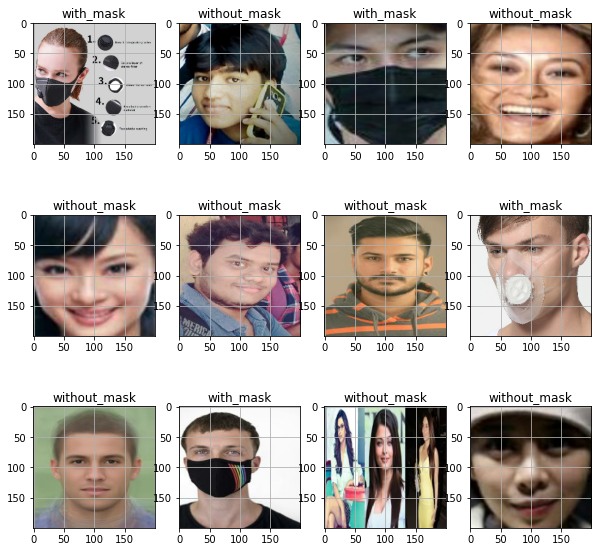

In [21]:
plt.figure(figsize=(10, 10))
for images, labels in testing_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(testing_ds.class_names[labels[i]])
    plt.grid(True)

In [22]:
## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Now build a deep neural network and train it and see how you do

In [23]:
inputs = Input(shape=(200, 200, 3))

# 2 Convolutional layers each followed by max pooling
x = Conv2D(32, kernel_size=(5, 5), kernel_initializer='he_normal')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Here we'll add a single Dense layer before the prediction
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 196, 196, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 196, 196, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 196, 196, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 64)       

In [24]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
             metrics=['accuracy'])
model.fit(training_ds, epochs=5,
         validation_data=(testing_ds))

Epoch 1/5
152/152 [==============================] - 750s 5s/step - loss: 1.8993 - accuracy: 0.7819 - val_loss: 0.3743 - val_accuracy: 0.8550
Epoch 2/5
152/152 [==============================] - 763s 5s/step - loss: 0.3385 - accuracy: 0.8747 - val_loss: 0.2782 - val_accuracy: 0.8775
Epoch 3/5
152/152 [==============================] - 722s 5s/step - loss: 0.2894 - accuracy: 0.8928 - val_loss: 0.2807 - val_accuracy: 0.8728
Epoch 4/5
152/152 [==============================] - 686s 5s/step - loss: 0.2444 - accuracy: 0.8997 - val_loss: 0.2093 - val_accuracy: 0.9166
Epoch 5/5
152/152 [==============================] - 648s 4s/step - loss: 0.1988 - accuracy: 0.9189 - val_loss: 0.4058 - val_accuracy: 0.8695


In [27]:
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
Y_pred = model.predict(testing_ds)
y_pred = [1 * (x[0]>=0.5) for x in Y_pred]
y_true = np.concatenate([y for x, y in testing_ds], axis=0)

In [30]:

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[566 176]
 [ 21 747]]
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       742
           1       0.81      0.97      0.88       768

    accuracy                           0.87      1510
   macro avg       0.89      0.87      0.87      1510
weighted avg       0.89      0.87      0.87      1510

